# Active Domain Adaptation for Regression

In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import uncertainty_toolbox as uct

## Superconductivity data set

The data set is available on-line, at https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data.
See Hamidieh (2018) for more information.

There are two files:
- `train.csv` that contains 81 features extracted from 21263 superconductors along with the critical temperature in the 82nd column;
- `unique_m.csv` that contains the chemical formula broken up for all the 21263 superconductors from the train.csv file. The last two columns have the critical temperature and chemical formula.

The goal is to predict the critical temperature.

In [2]:
train = pd.read_csv("data/superconduct/train.csv")
train

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


In [3]:
unique_m = pd.read_csv("data/superconduct/unique_m.csv")
unique_m

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.00,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.00,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.00,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.00,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.00,Ba0.3La1.7Cu1O4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,2.44,Tm0.84Lu0.16Fe3Si5
21259,0.0,0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,122.10,Tl1Ba2Ca3Cu4O11
21260,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1.98,Nb0.8Pd0.2
21261,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1.84,Nb0.69Pd0.31


### Data Preparation

Accoring to Mathelin et al. (2022) and Pardoe & Stone (2010).

In [4]:
TARGET_COLUMN = "critical_temp"
SPLIT_COLUMN = "wtd_std_Valence"

In [5]:
X = train.drop([TARGET_COLUMN, SPLIT_COLUMN], axis=1).values
y = train[[TARGET_COLUMN]].values

In [6]:
percentiles = train[SPLIT_COLUMN].quantile([0.25, 0.5, 0.75])
percentiles

0.25    0.306892
0.50    0.500000
0.75    1.020436
Name: wtd_std_Valence, dtype: float64

In [7]:
index_source = (train[SPLIT_COLUMN] <= percentiles[0.25])
index_target = (percentiles[0.75] < train[SPLIT_COLUMN])

X_source, y_source = X[index_source], y[index_source]
X_target, y_target = X[index_target], y[index_target]

X_scaler = StandardScaler()
X_source = X_scaler.fit_transform(X_source)
X_target = X_scaler.transform(X_target)

y_scaler = StandardScaler()
y_source = y_scaler.fit_transform(y_source)
y_target = y_scaler.transform(y_target)

N_FEATURES = X_source.shape[1]
X_source.shape, y_source.shape, X_target.shape, y_target.shape

((5319, 80), (5319, 1), (5314, 80), (5314, 1))

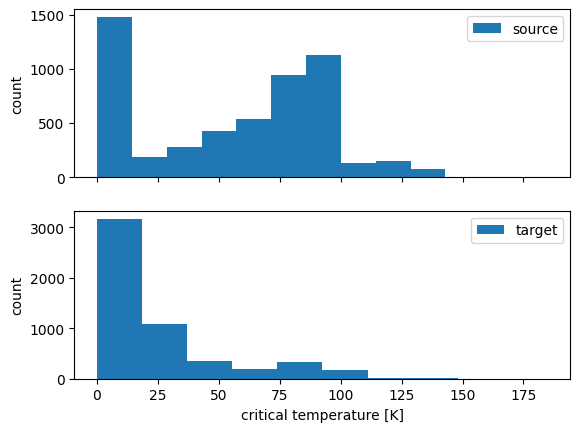

In [8]:
_, axs = plt.subplots(nrows=2, sharex=True)
axs[0].hist(y_scaler.inverse_transform(y_source), label="source")
axs[1].hist(y_scaler.inverse_transform(y_target), label="target")
axs[1].set_xlabel("critical temperature [K]")
for ax in axs:
    ax.legend()
    ax.set_ylabel("count")

In [9]:
X_source_train, X_source_test, y_source_train, y_source_test = train_test_split(
    X_source, y_source, test_size=0.2, random_state=60)
X_source_train.shape, X_source_test.shape

((4255, 80), (1064, 80))

In [10]:
X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
    X_target, y_target, test_size=0.2, random_state=96)
X_target_train.shape, X_target_test.shape

((4251, 80), (1063, 80))

## Baselines

Simplification: single-shot batch active learning (Viering et al., 2019).

There are several baselines that have to be considered:
1. model trained on source data;
2. model trained on target data;
3. random query strategy.

In [11]:
BS = 2048   # batch size for testing
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HYPERPARAMS = {"bs": 128, "n_epochs": 256}
DEVICE

device(type='cuda')

In [12]:
def to_tensor(array):
    return torch.from_numpy(array).float().to(DEVICE)

trainset_source = TensorDataset(to_tensor(X_source_train), to_tensor(y_source_train))
testset_source = TensorDataset(to_tensor(X_source_test), to_tensor(y_source_test))
trainset_target = TensorDataset(to_tensor(X_target_train), to_tensor(y_target_train))
testset_target = TensorDataset(to_tensor(X_target_test), to_tensor(y_target_test))

In [13]:
def nll(mean_pred, var_pred, mean):
    return torch.log(var_pred) + torch.square(mean - mean_pred) / var_pred

def crps(mean_pred, var_pred, mean):
    std_pred = torch.sqrt(var_pred)
    mean_std = (mean - mean_pred) / std_pred
    pi = torch.tensor(math.pi)
    pdf = (1.0 / torch.sqrt(2.0 * pi)) * torch.exp(-0.5 * torch.square(mean_std))
    cdf = 0.5 + 0.5 * torch.erf(mean_std / torch.sqrt(torch.tensor(2.0)))
    return std_pred * (mean_std * (2.0 * cdf - 1.0) + 2.0 * pdf - 1.0 / torch.sqrt(pi))

In [14]:
def get_y(dataset):
    return torch.concat([batch[-1] for batch in DataLoader(dataset, batch_size=BS)]).cpu()

In [15]:
class Model(nn.Module):
    def __init__(self, loss_function):
        super(Model, self).__init__()
        self.loss_function = loss_function
        N_HIDDEN = 64
        self.model = nn.Sequential(
            nn.Linear(N_FEATURES, N_HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(N_HIDDEN, N_HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(N_HIDDEN, 2))    # mean and variance
        self.to(DEVICE)

    def forward(self, X):
        output = self.model(X)
        mean, var = output[:, :1], output[:, 1:]
        var = F.softplus(var) + 1e-6
        return mean, var

    @torch.no_grad()
    def predict(self, dataset):
        self.eval()
        dataloader = DataLoader(dataset, batch_size=BS)
        output = [self(batch[0]) for batch in dataloader]
        mean, var = tuple(zip(*output))
        mean, var = torch.concat(mean), torch.concat(var)
        return mean.cpu(), var.cpu()

    def test(self, testset):
        y_pred = self.predict(testset)
        y = get_y(testset)
        return self.loss(y_pred, y)
    
    def loss(self, y_pred, y):
        return torch.mean(self.loss_function(*y_pred, y))

    def train_epoch(self, trainloader, optimiser):
        self.train()
        for X_batch, y_batch in trainloader:
            optimiser.zero_grad()
            loss = self.loss(self(X_batch), y_batch)
            loss.backward()
            optimiser.step()
        return self

    def train_epochs(self, trainset, testset, hyperparams):
        optimiser = optim.Adam(self.parameters())
        trainloader = DataLoader(trainset, batch_size=hyperparams["bs"], shuffle=True)
        losses = torch.zeros(hyperparams["n_epochs"] + 1)
        losses[0] = self.test(testset)
        for epoch in range(1, hyperparams["n_epochs"] + 1):
            self.train_epoch(trainloader, optimiser)
            losses[epoch] = self.test(testset)
        _, ax = plt.subplots()
        ax.scatter(torch.arange(hyperparams["n_epochs"] + 1), losses)
        ax.set_ylabel("loss")
        ax.set_xlabel("epoch")
        return self

In [16]:
def mae(y_pred, y):
    """Compute mean absolute error."""
    return np.mean(np.abs(y - y_pred))

def rmse(y_pred, y):
    """Compute root-mean-square error."""
    return np.sqrt(np.mean(np.square(y - y_pred)))

def evaluate(model, dataset, y_scaler=y_scaler):
    y_pred, var_pred = model.predict(dataset)
    y = get_y(dataset)
    y_pred = y_scaler.inverse_transform(y_pred)
    y = y_scaler.inverse_transform(y)
    return {"MAE": mae(y_pred, y), "RMSE": rmse(y_pred, y)}

### Negative Log Likelihood (NLL)

{'MAE': 10.83580493256366, 'RMSE': 14.850242896264369}

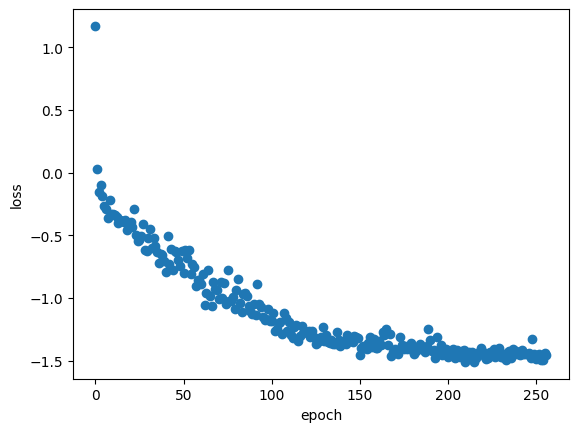

In [17]:
model_source_nll = Model(nll).train_epochs(trainset_source, testset_source, HYPERPARAMS)
evaluate(model_source_nll, testset_source)

In [18]:
evaluate(model_source_nll, testset_target)

{'MAE': 13.591758460674482, 'RMSE': 20.25223348289296}

{'MAE': 7.2220957750259895, 'RMSE': 11.87777366816717}

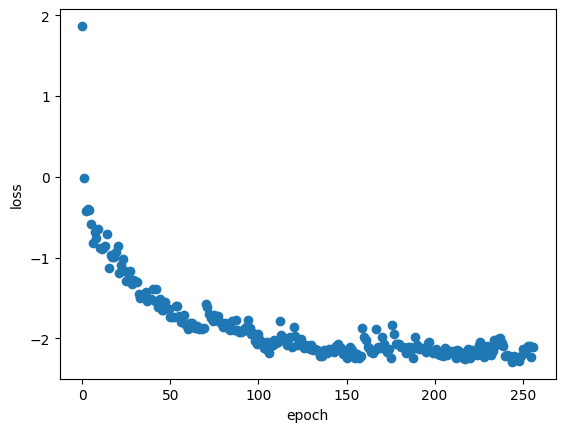

In [19]:
model_target_nll = Model(nll).train_epochs(trainset_target, testset_target, HYPERPARAMS)
evaluate(model_target_nll, testset_target)

### Continuous Ranked Probability Score (CRPS)

{'MAE': 9.137840898057608, 'RMSE': 13.411439399792568}

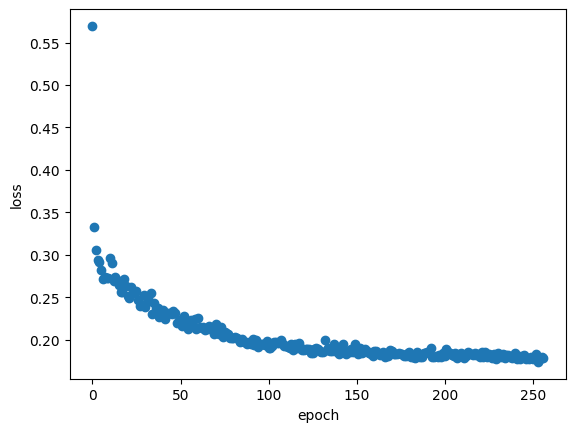

In [20]:
model_source_crps = Model(crps).train_epochs(trainset_source, testset_source, HYPERPARAMS)
evaluate(model_source_crps, testset_source)

In [21]:
evaluate(model_source_crps, testset_target)

{'MAE': 20.13002553749693, 'RMSE': 25.89809303386526}

{'MAE': 6.141892850936323, 'RMSE': 10.59073059061766}

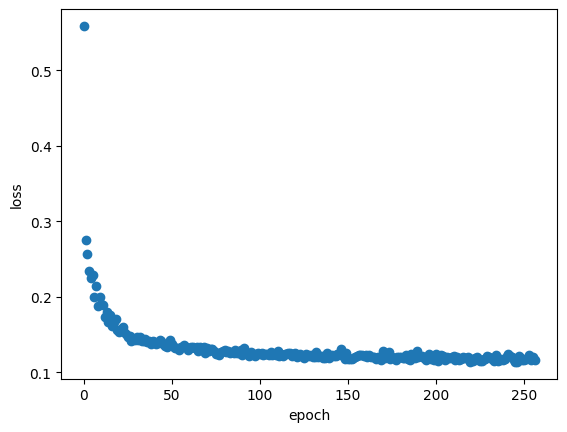

In [22]:
model_target_crps = Model(crps).train_epochs(trainset_target, testset_target, HYPERPARAMS)
evaluate(model_target_crps, testset_target)

## Uncertainty Evaluation

PIT histogram and the uncertainty toolbox by Chung et al. (2021).

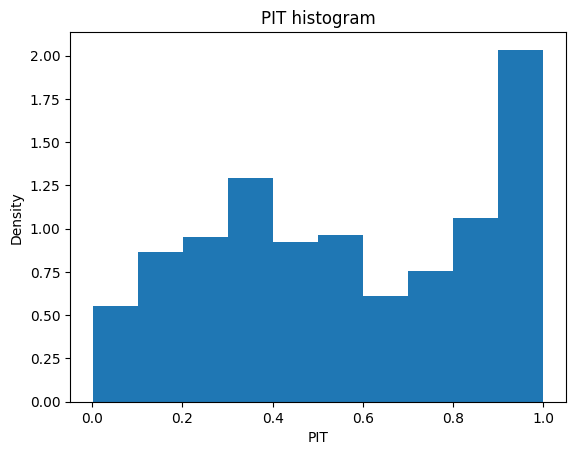

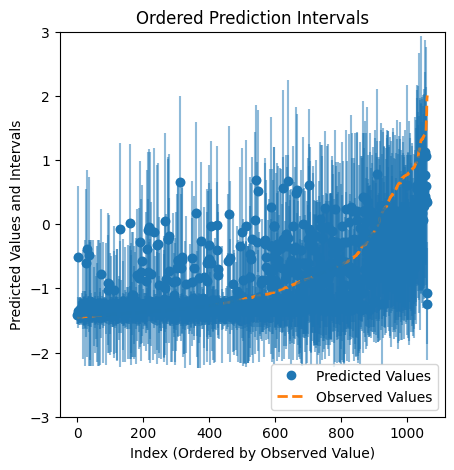

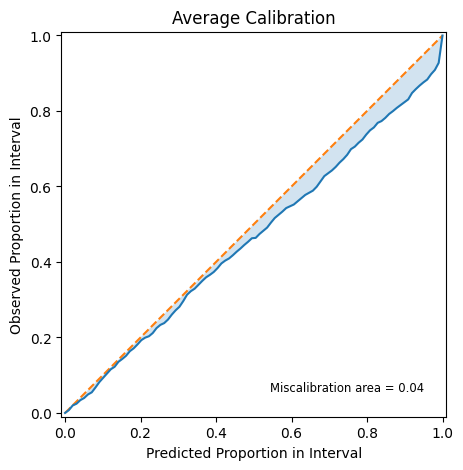

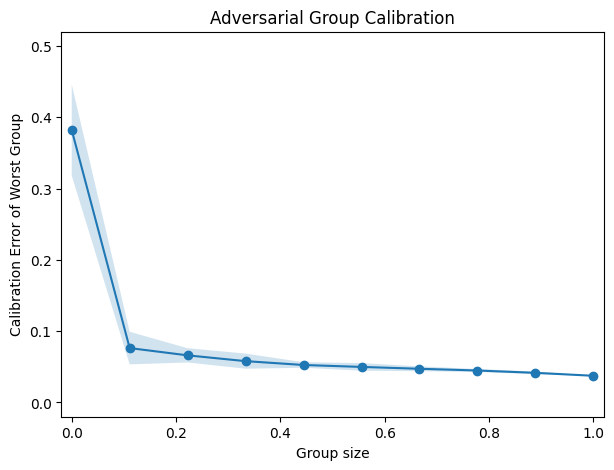

In [23]:
def plot_pit_histogram(mean_pred, std_pred, y):
    _, ax = plt.subplots()
    ax.hist(norm.cdf(y, loc=mean_pred, scale=std_pred), density=True)
    ax.set_title("PIT histogram")
    ax.set_xlabel("PIT")
    ax.set_ylabel("Density")

def evaluate_uncertainty(model, dataset):
    # TODO should I use the y_scaler?
    y = get_y(dataset).squeeze().numpy()
    mean_pred, var_pred = model.predict(dataset)
    mean_pred = mean_pred.squeeze().numpy()
    std_pred = np.sqrt(var_pred).squeeze().numpy()
    plot_pit_histogram(mean_pred, std_pred, y)
    uct.viz.plot_intervals_ordered(mean_pred, std_pred, y)
    uct.viz.plot_calibration(mean_pred, std_pred, y)
    uct.viz.plot_adversarial_group_calibration(mean_pred, std_pred, y)

evaluate_uncertainty(model_source_nll, testset_target)

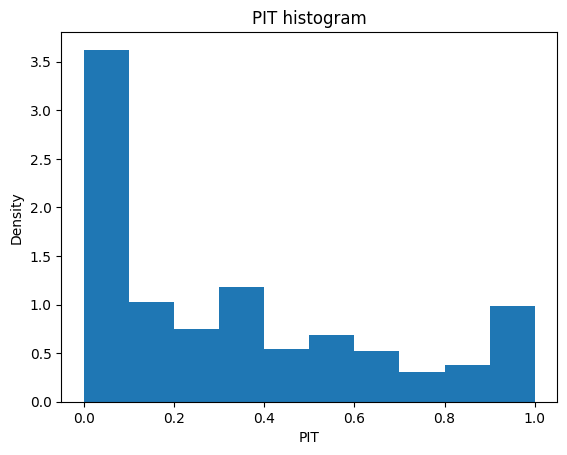

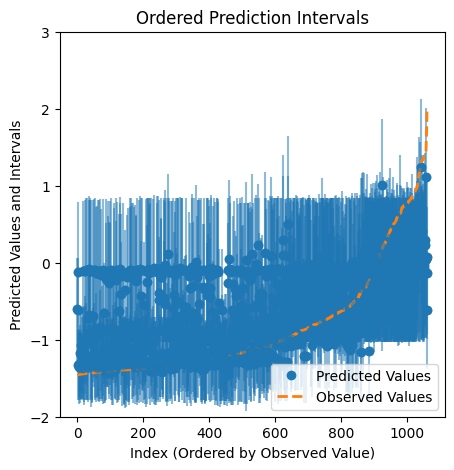

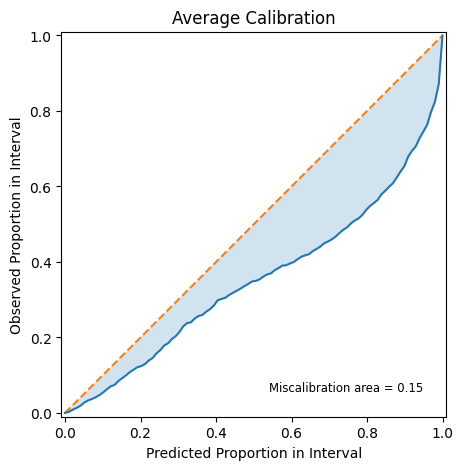

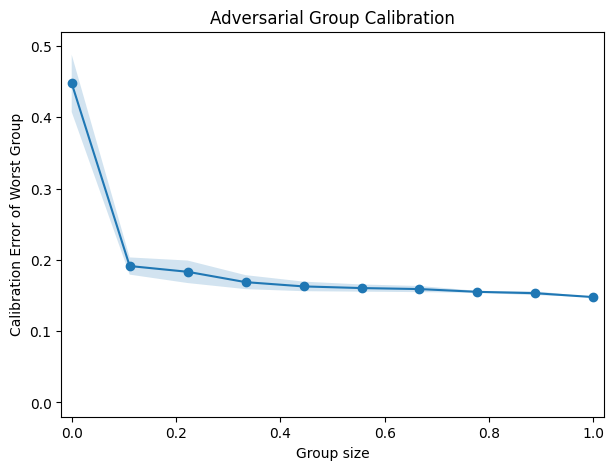

In [24]:
evaluate_uncertainty(model_source_crps, testset_target)

## Deep Ensemble

In [25]:
class DeepEnsemble(Model):
    def __init__(self, loss_function, M):
        super(DeepEnsemble, self).__init__(loss_function)
        self.M = M
        self.models = []
        for i, m in enumerate(range(M)):
            self.models.append(Model(loss_function))
            self.add_module("model-" + str(i), self.models[i])

    @torch.no_grad()
    def predict(self, dataset):
        outputs = [model.predict(dataset) for model in self.models]
        means, variances = tuple(zip(*outputs))
        means = torch.concat(means, dim=1)
        variances = torch.concat(variances, dim=1)
        mean = torch.mean(means, dim=1, keepdim=True)
        var = torch.mean(variances + torch.square(means), dim=1, keepdim=True) - torch.square(mean)
        return mean, var
    
    def train_epoch(self, trainloader, optimiser):
        for model in self.models:
            model.train_epoch(trainloader, optimiser)
        return self

    def train_epochs(self, trainset, testset, hyperparams):
        for i, model in enumerate(self.models):
            model.train_epochs(trainset, testset, hyperparams)
        return self

{'MAE': 11.938954804637133, 'RMSE': 15.677069995978737}

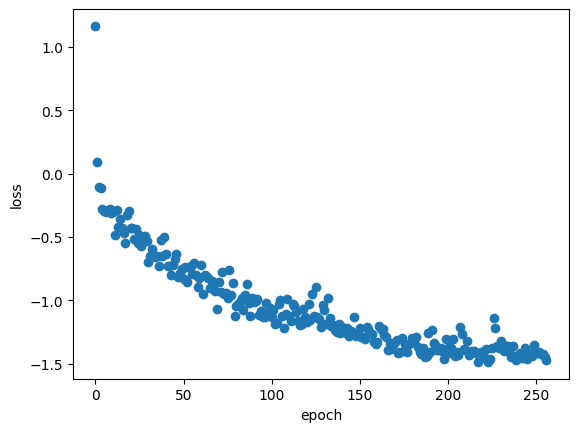

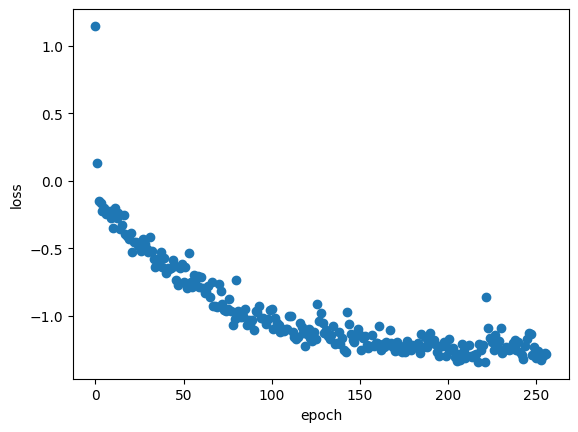

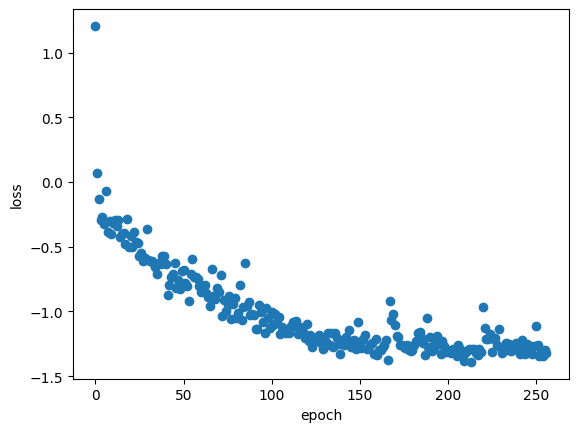

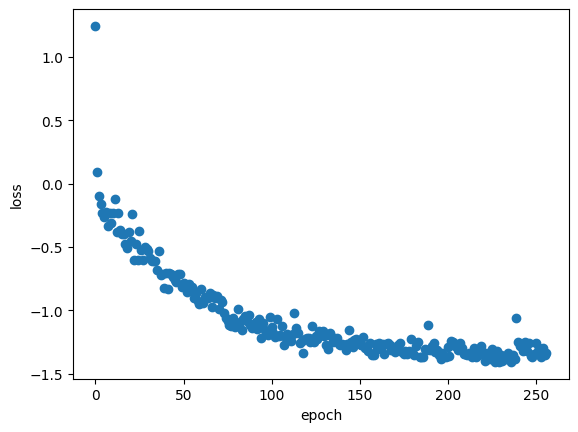

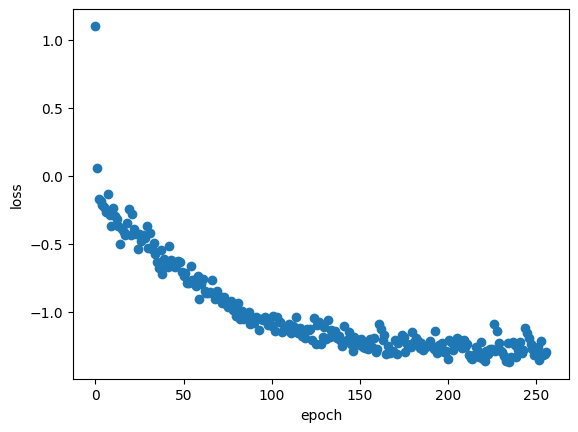

In [26]:
ensemble_source_nll = DeepEnsemble(nll, M=5).train_epochs(trainset_source, testset_source, HYPERPARAMS)
evaluate(ensemble_source_nll, testset_source)

{'MAE': 9.278117054933022, 'RMSE': 13.14045984389485}

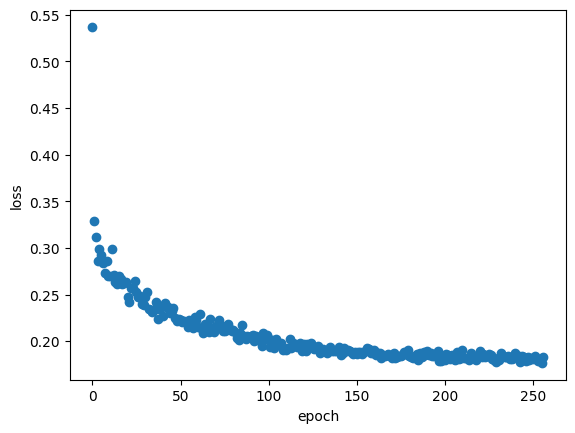

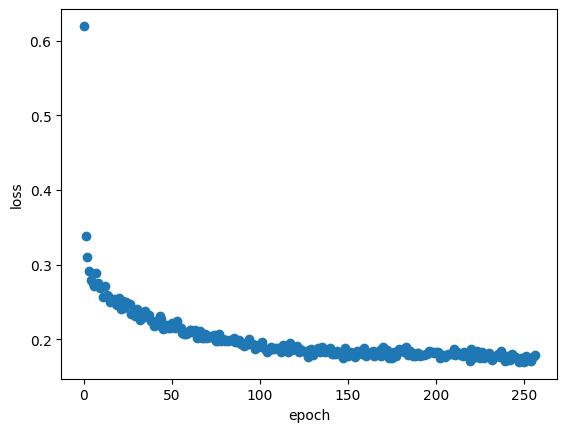

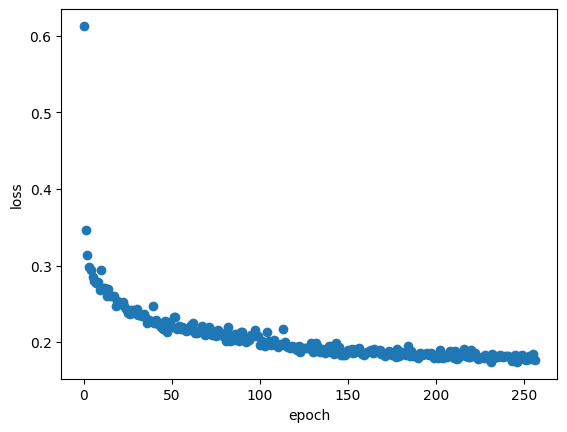

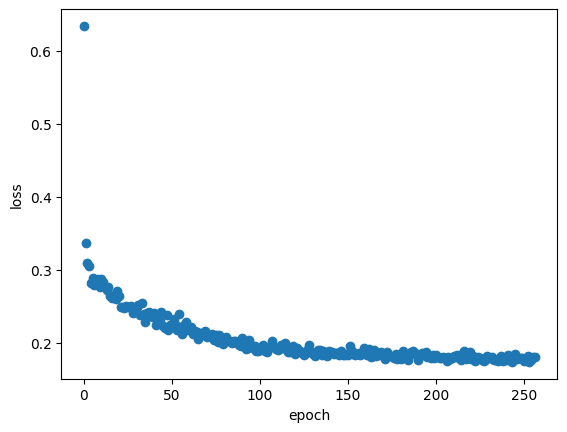

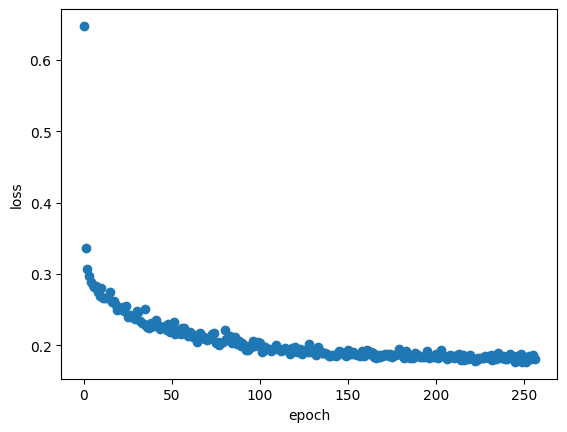

In [27]:
ensemble_source_crps = DeepEnsemble(crps, M=5).train_epochs(trainset_source, testset_source, HYPERPARAMS)
evaluate(ensemble_source_crps, testset_source)

In [28]:
evaluate(ensemble_source_nll, testset_target)

{'MAE': 11.887227503169775, 'RMSE': 17.592278346848353}

In [29]:
evaluate(ensemble_source_crps, testset_target)

{'MAE': 18.70473975736521, 'RMSE': 24.351688557694946}

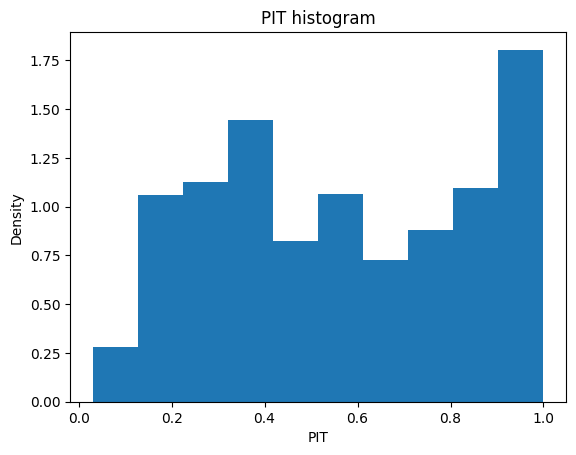

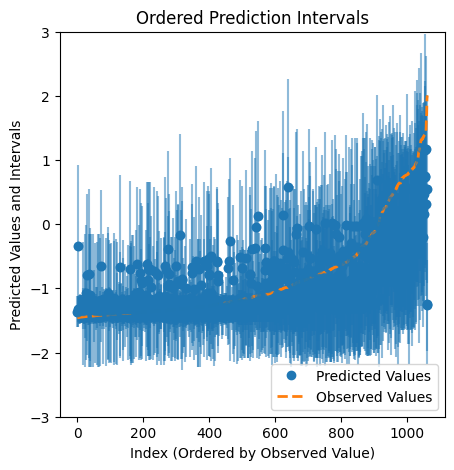

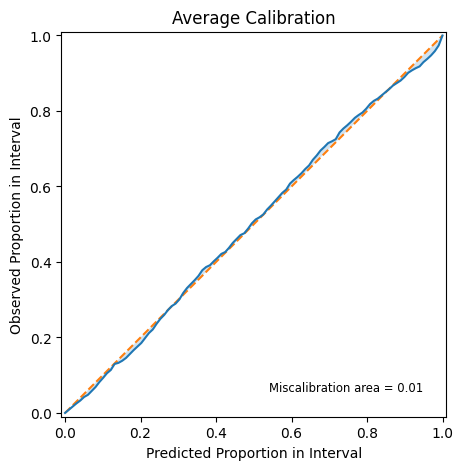

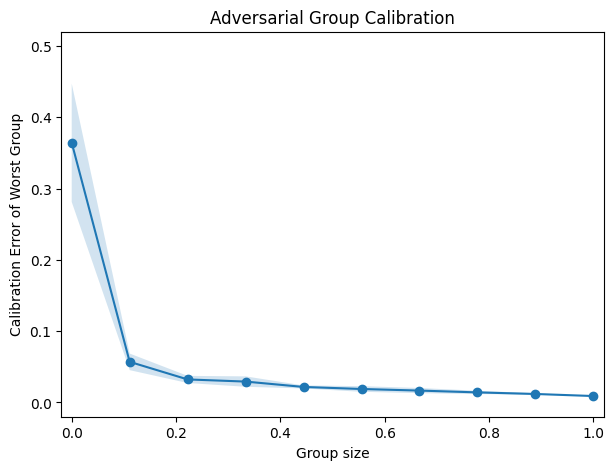

In [30]:
evaluate_uncertainty(ensemble_source_nll, testset_target)

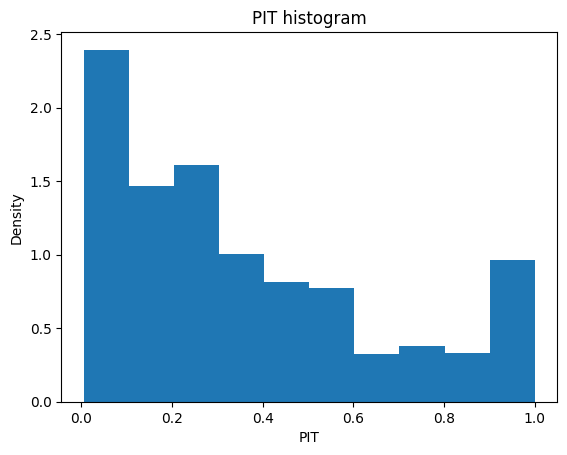

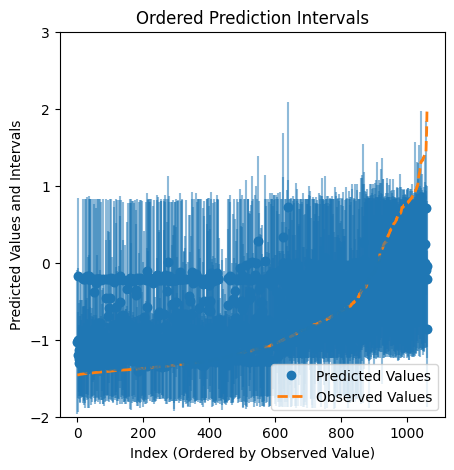

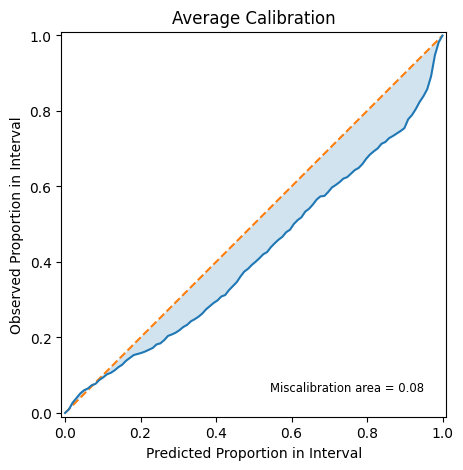

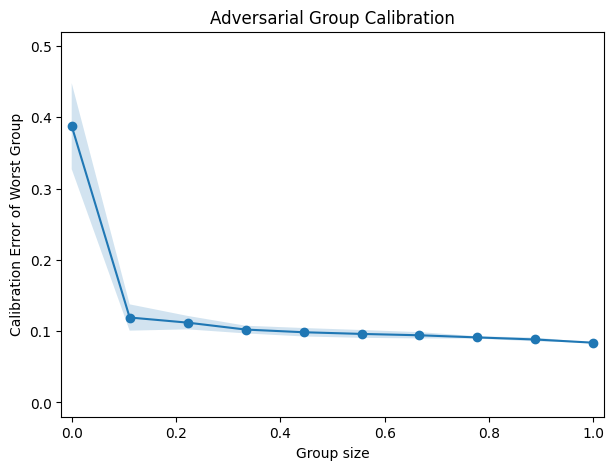

In [31]:
evaluate_uncertainty(ensemble_source_crps, testset_target)